In [2]:
import tensorflow as tf
import pandas as pd
import string
import re
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import nltk
import spacy
import sys
from spacy.lang.en import English
import en_core_web_sm
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

print(tf.__version__)  # 2.0.0-beta0

2022-09-16 11:11:00.390639: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-16 11:11:00.686166: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-16 11:11:00.727862: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-16 11:11:00.727883: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

2.10.0


In [3]:
df = pd.read_json("Sarcasm_Dataset.json", lines=True)
df = df[['headline', 'is_sarcastic']]
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [11]:
# check for columns with null values
df.is_sarcastic.isnull().any() # no missing values in is_sarcastic column
df.headline.isnull().any() # no missing values in headline column


False

In [12]:
df['headline'] = df.headline.apply(lambda x:x.lower())  # convert all words in headline into lower case 
df['headline'] = df.headline.apply(lambda x: ' '.join(word.strip(string.punctuation) for word in x.split()))  # remove all punctuations in headline


In [13]:
df['headline_count'] = df.headline.apply(lambda x: len(list(x.split())))
df['headline_unique_word_count'] = df.headline.apply(lambda x: len(set(x.split())))
df['headline_has_digits'] = df.headline.apply(lambda x: bool(re.search(r'\d', x)))
df


,headline,is_sarcastic,headline_count,headline_unique_word_count,headline_has_digits
0,former versace store clerk sues over secret bl...,0,12,12,False
1,the roseanne revival catches up to our thorny ...,0,14,14,False
2,mom starting to fear son's web series closest ...,1,14,13,False
3,boehner just wants wife to listen not come up ...,1,13,13,False
4,j.k rowling wishes snape happy birthday in the...,0,11,11,False
...,...,...,...,...,...
26704,american politics in moral free-fall,0,5,5,False
26705,america's best 20 hikes,0,4,4,True
26706,reparations and obama,0,3,3,False
26707,israeli ban targeting boycott supporters raise...,0,8,8,False


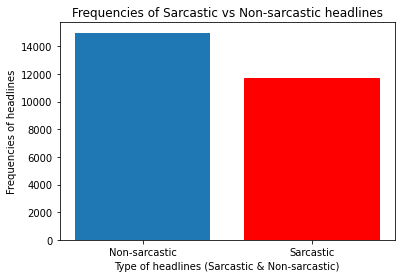

In [14]:
sarcastic_dat = df.groupby('is_sarcastic').count()
sarcastic_dat.index = ['Non-sarcastic','Sarcastic']
plt.xlabel('Type of headlines (Sarcastic & Non-sarcastic)')
plt.ylabel('Frequencies of headlines')
plt.xticks(fontsize=10)
plt.title('Frequencies of Sarcastic vs Non-sarcastic headlines')
bar_graph = plt.bar(sarcastic_dat.index, sarcastic_dat.headline_count)
bar_graph[1].set_color('r')
plt.show()

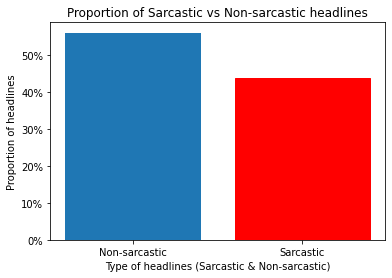

Non-sarcastic    0.56
Sarcastic        0.44
Name: headline_count, dtype: float64

In [15]:
plt.xlabel('Type of headlines (Sarcastic & Non-sarcastic)')
plt.ylabel('Proportion of headlines')
plt.xticks(fontsize=10)
plt.title('Proportion of Sarcastic vs Non-sarcastic headlines')
bar_graph = plt.bar(sarcastic_dat.index, sarcastic_dat.headline_count / sarcastic_dat.headline_count.sum())
bar_graph[1].set_color('r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

# This is not an imbalanced class dataset
# Non-sarcastic    0.56
# Sarcastic        0.44
round(sarcastic_dat.headline_count / sarcastic_dat.headline_count.sum(), 2)


In [16]:
all_dat = df.groupby('headline_count').count()
sarcastic_dat1 = df[df.is_sarcastic==1]
sarcastic_dat = sarcastic_dat1.groupby('headline_count').count()
not_sarcastic_dat1 = df[df.is_sarcastic==0]
not_sarcastic_dat = not_sarcastic_dat1.groupby('headline_count').count()


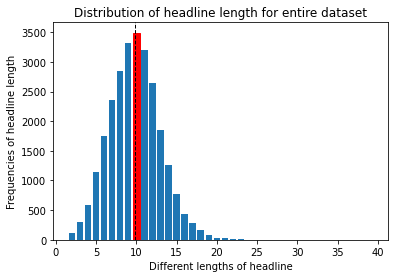

In [17]:
plt.xlabel('Different lengths of headline')
plt.ylabel('Frequencies of headline length')
plt.xticks(fontsize=10)
plt.title('Distribution of headline length for entire dataset')
bar_graph = plt.bar(all_dat.index, all_dat.headline)
bar_graph[8].set_color('r')
plt.axvline(df.headline_count.mean(), color='k', linestyle='dashed', linewidth=1)  # median is 10 words in a headline
plt.show()


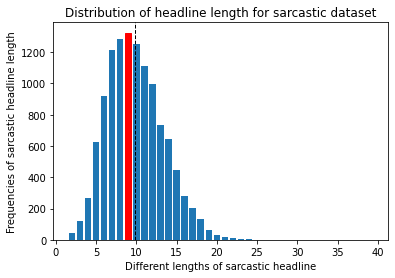

In [18]:
plt.xlabel('Different lengths of sarcastic headline')
plt.ylabel('Frequencies of sarcastic headline length')
plt.xticks(fontsize=10)
plt.title('Distribution of headline length for sarcastic dataset')
bar_graph = plt.bar(sarcastic_dat.index, sarcastic_dat.headline)
bar_graph[7].set_color('r')
plt.axvline(sarcastic_dat1.headline_count.mean(), color='k', linestyle='dashed', linewidth=1)  # median is 10 words in a headline
plt.show()


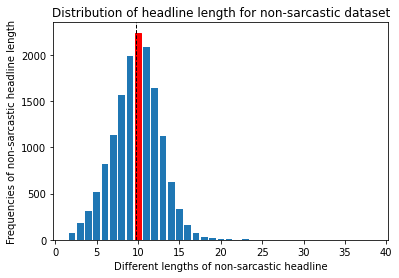

In [19]:
plt.xlabel('Different lengths of non-sarcastic headline')
plt.ylabel('Frequencies of non-sarcastic headline length')
plt.xticks(fontsize=10)
plt.title('Distribution of headline length for non-sarcastic dataset')
bar_graph = plt.bar(not_sarcastic_dat.index, not_sarcastic_dat.headline)
bar_graph[8].set_color('r')
plt.axvline(not_sarcastic_dat1.headline_count.mean(), color='k', linestyle='dashed', linewidth=1)  # median is 10 words in a headline
plt.show()

# difference in the length of sarcastic and non-sarcastic headlines is not significant. 
# median and mean length of headlines is around 10 words


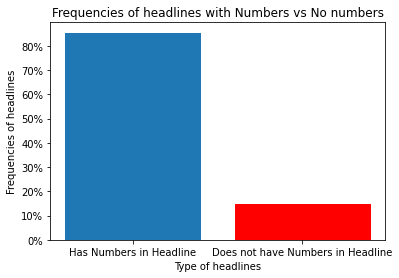

In [20]:
digits_dat = df.groupby('headline_has_digits').count()
digits_dat.index = ['Has Numbers in Headline','Does not have Numbers in Headline']


plt.xlabel('Type of headlines')
plt.ylabel('Frequencies of headlines')
plt.xticks(fontsize=10)
plt.title('Frequencies of headlines with Numbers vs No numbers')
bar_graph = plt.bar(digits_dat.index, digits_dat.headline / digits_dat.headline_count.sum())
bar_graph[1].set_color('r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

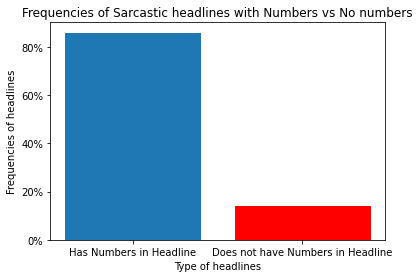

In [21]:
sarcastic_digits_dat = df[df.is_sarcastic==1].groupby('headline_has_digits').count()
sarcastic_digits_dat.index = ['Has Numbers in Headline','Does not have Numbers in Headline']


plt.xlabel('Type of headlines')
plt.ylabel('Frequencies of headlines')
plt.xticks(fontsize=10)
plt.title('Frequencies of Sarcastic headlines with Numbers vs No numbers')
bar_graph = plt.bar(sarcastic_digits_dat.index, sarcastic_digits_dat.headline / sarcastic_digits_dat.headline_count.sum())
bar_graph[1].set_color('r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()


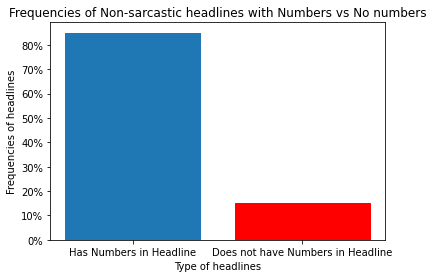

In [22]:
not_sarcastic_digits_dat = df[df.is_sarcastic==0].groupby('headline_has_digits').count()
not_sarcastic_digits_dat.index = ['Has Numbers in Headline','Does not have Numbers in Headline']


plt.xlabel('Type of headlines')
plt.ylabel('Frequencies of headlines')
plt.xticks(fontsize=10)
plt.title('Frequencies of Non-sarcastic headlines with Numbers vs No numbers')
bar_graph = plt.bar(not_sarcastic_digits_dat.index, not_sarcastic_digits_dat.headline / not_sarcastic_digits_dat.headline_count.sum())
bar_graph[1].set_color('r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [23]:
print(round(digits_dat.headline / digits_dat.headline_count.sum(),2))
print(round(sarcastic_digits_dat.headline / sarcastic_digits_dat.headline_count.sum(),2))
print(round(not_sarcastic_digits_dat.headline / not_sarcastic_digits_dat.headline_count.sum(),2))

# difference in the use of numbers/statistics in sarcastic and non-sarcastic headlines is not significant. 
# ~85% headlines uses numbers


Has Numbers in Headline              0.85
Does not have Numbers in Headline    0.15
Name: headline, dtype: float64
Has Numbers in Headline              0.86
Does not have Numbers in Headline    0.14
Name: headline, dtype: float64
Has Numbers in Headline              0.85
Does not have Numbers in Headline    0.15
Name: headline, dtype: float64


In [24]:
nlp = en_core_web_sm.load()
parser = English()
en_stop = set(nltk.corpus.stopwords.words('english'))


def tokenize(text):
    """this function is to tokenize the headline into a list of individual words"""
    lda_tokens = []
    tokens = parser(text)  # need to use parser for python to treat the list as words
    for token in tokens:
        if token.orth_.isspace():  # to ignore any whitespaces in the headline, so that token list does not contain whitespaces 
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)   # tokens (headlines) are already in lowercase
    return lda_tokens


def get_lemma(word):
    """this function is to lemmatize the words in a headline into its root form"""
    lemma = wn.morphy(word)  # converts the word into root form from wordnet
    if lemma is None:
        return word
    else:
        return lemma
    

def prepare_text_for_lda(text):
    tokens = tokenize(text)  # parse and tokenize the headline into a list of words
    tokens = [token for token in tokens if len(token) > 4]  # remove headlines with only length of 4 words or less
    tokens = [token for token in tokens if token not in en_stop]  # remove stopwords in the headline
    tokens = [get_lemma(token) for token in tokens]  # lemmatize the words in the headline
    return tokens

In [25]:
text_data = []
for headline in df.headline:
    tokens = prepare_text_for_lda(headline)
    text_data.append(tokens)


In [26]:
from gensim import corpora
import pickle

dictionary = corpora.Dictionary(text_data)  # Convert all headlines into a corpus of words, with each word as a token
corpus = [dictionary.doc2bow(text) for text in text_data]  # Convert each headline (a list of words) into the bag-of-words format. (Word ID, Count of word)
pickle.dump(corpus, open('corpus.pkl', 'wb'))  
dictionary.save('dictionary.gensim')  # takes a while to run the dictionary and corpus


In [27]:
import gensim

NUM_TOPICS = [3, 5, 10]
# passes: Number of passes through the corpus during training
# alpha: priori on the distribution of the topics in each document.
# The higher the alpha, the higher the likelihood that document contains a wide range of topics, vice versa. 
# beta: priori on the distribution of the words in each topic.
# The higher the beta, the higher the likelihood that topic contains a wide range of words, vice versa.
# we do not alter / fine tune the default values of alpha and beta
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS[1], id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=5)
topics


[(0,
  '0.025*"woman" + 0.005*"report" + 0.005*"business" + 0.005*"medium" + 0.005*"introduce"'),
 (1,
  '0.010*"clinton" + 0.008*"school" + 0.007*"american" + 0.006*"court" + 0.006*"find"'),
 (2,
  '0.045*"trump" + 0.013*"donald" + 0.010*"house" + 0.009*"white" + 0.008*"change"'),
 (3,
  '0.006*"friend" + 0.006*"report" + 0.006*"would" + 0.005*"people" + 0.005*"make"'),
 (4,
  '0.014*"world" + 0.008*"police" + 0.005*"family" + 0.005*"could" + 0.005*"break"')]

In [28]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 3, id2word=dictionary, passes=15)
ldamodel.save('model3.gensim')
topics = ldamodel.print_topics(num_words=5)
topics

[(0,
  '0.008*"people" + 0.006*"change" + 0.005*"watch" + 0.004*"school" + 0.004*"family"'),
 (1,
  '0.012*"trump" + 0.008*"house" + 0.006*"white" + 0.006*"clinton" + 0.006*"obama"'),
 (2,
  '0.021*"trump" + 0.012*"woman" + 0.010*"american" + 0.010*"donald" + 0.009*"report"')]

In [29]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 10, id2word=dictionary, passes=15)
ldamodel.save('model10.gensim')
topics = ldamodel.print_topics(num_words=5)
topics


[(0,
  '0.017*"police" + 0.016*"video" + 0.012*"reveal" + 0.012*"woman" + 0.010*"finally"'),
 (1,
  '0.018*"really" + 0.014*"going" + 0.011*"local" + 0.009*"health" + 0.009*"sander"'),
 (2,
  '0.012*"make" + 0.012*"release" + 0.009*"introduce" + 0.009*"father" + 0.008*"single"'),
 (3,
  '0.027*"house" + 0.023*"white" + 0.022*"clinton" + 0.015*"state" + 0.012*"hillary"'),
 (4,
  '0.015*"study" + 0.013*"court" + 0.013*"republican" + 0.013*"find" + 0.010*"candidate"'),
 (5,
  '0.014*"take" + 0.011*"business" + 0.010*"employee" + 0.010*"country" + 0.008*"email"'),
 (6,
  '0.100*"trump" + 0.030*"donald" + 0.019*"change" + 0.014*"america" + 0.013*"child"'),
 (7,
  '0.011*"parent" + 0.011*"million" + 0.011*"reason" + 0.009*"bring" + 0.009*"demand"'),
 (8,
  '0.043*"report" + 0.031*"woman" + 0.013*"black" + 0.012*"american" + 0.011*"people"'),
 (9,
  '0.022*"world" + 0.012*"congress" + 0.009*"former" + 0.009*"today" + 0.008*"violence"')]

In [33]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
lda_display = gensimvis.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)



/home/shivani/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [35]:
lda3 = gensim.models.ldamodel.LdaModel.load('model3.gensim')
lda_display3 = gensimvis.prepare(lda3, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display3)

/home/shivani/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [37]:
lda10 = gensim.models.ldamodel.LdaModel.load('model10.gensim')
lda_display10 = gensimvis.prepare(lda10, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display10)



/home/shivani/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [38]:
from numpy import mean

sarcastic = list(df.is_sarcastic == 1)
tuple_list = []
for headline in sarcastic:
    sarcastic = lda10[corpus[headline]]
    for tuple_ in sarcastic:
        tuple_list.append(tuple_)

print('For LDA model with 10 clusters:')
print('\nFor Sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

not_sarcastic = list(df.is_sarcastic == 0)
tuple_list = []
for headline in not_sarcastic:
    not_sarcastic = lda10[corpus[headline]]
    for tuple_ in not_sarcastic:
        tuple_list.append(tuple_)
        

print('\nFor Non-sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

# LDA model with 10 clusters not differentiable between sarcastic and not sarcastic headlines.
# Not very interpretable

For LDA model with 10 clusters:

For Sarcastic Dataset:
[(0, 0.067389145), (1, 0.36339292), (2, 0.082558386), (3, 0.012489239), (4, 0.01248951), (5, 0.01248924), (6, 0.012489239), (7, 0.23197865), (8, 0.012490588), (9, 0.1922331)]

For Non-sarcastic Dataset:
[(0, 0.082663976), (1, 0.2870352), (2, 0.067314684), (3, 0.012493813), (4, 0.012494157), (5, 0.012493813), (6, 0.0124938125), (7, 0.29303363), (8, 0.012494982), (9, 0.2074819)]


In [39]:
sarcastic = list(df.is_sarcastic == 1)
tuple_list = []
for headline in sarcastic:
    sarcastic = lda[corpus[headline]]
    for tuple_ in sarcastic:
        tuple_list.append(tuple_)

print('For LDA model with 5 clusters:')
print('For Sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

not_sarcastic = list(df.is_sarcastic == 0)
tuple_list = []
for headline in not_sarcastic:
    not_sarcastic = lda[corpus[headline]]
    for tuple_ in not_sarcastic:
        tuple_list.append(tuple_)
        

print('\nFor Non-sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

# LDA model with 5 clusters not differentiable between sarcastic and not sarcastic headlines.
# Not very interpretable

For LDA model with 5 clusters:
For Sarcastic Dataset:
[(0, 0.15110941), (1, 0.023579886), (2, 0.024198087), (3, 0.7104011), (4, 0.09071153)]

For Non-sarcastic Dataset:
[(0, 0.123730905), (1, 0.023894083), (2, 0.024580523), (3, 0.7182404), (4, 0.10955411)]


In [40]:
sarcastic = list(df.is_sarcastic == 1)
tuple_list = []
for headline in sarcastic:
    sarcastic = lda3[corpus[headline]]
    for tuple_ in sarcastic:
        tuple_list.append(tuple_)

print('For LDA model with 3 clusters:')
print('For Sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

not_sarcastic = list(df.is_sarcastic == 0)
tuple_list = []
for headline in not_sarcastic:
    not_sarcastic = lda3[corpus[headline]]
    for tuple_ in not_sarcastic:
        tuple_list.append(tuple_)
        

print('\nFor Non-sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

# LDA model with 3 clusters not differentiable between sarcastic and not sarcastic headlines.
# Not very interpretable

For LDA model with 3 clusters:
For Sarcastic Dataset:
[(0, 0.27265587), (1, 0.2697707), (2, 0.4575734)]

For Non-sarcastic Dataset:
[(0, 0.33773535), (1, 0.2637575), (2, 0.39850718)]


/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alterna

# RNN with LSTM Architecture


In [1]:
train_data, test_data = train_test_split(df[['headline', 'is_sarcastic']], test_size=0.1)  # randomly splitting 10% of dataset to be training dataset 

training_sentences = list(train_data['headline'])
training_labels = list(train_data['is_sarcastic'])

testing_sentences = list(test_data['headline'])
testing_labels = list(test_data['is_sarcastic'])
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


NameError: name 'train_test_split' is not defined

In [43]:
vocab_size = 10000   # limit vector of words to the top 10,000 words
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

# no lemmatization, removal of stop words and stemming of headlines as we would like to maintain the syntax, literature integrity, sequence of words in LSTM.

In [44]:
# Model Definition with BiRNN (LSTM)
# with L1 Lasso Regularization, for feature selection
# Dropout, for robustness of recurrent neural networks
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

2022-09-13 17:55:55.184272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense (Dense)               (None, 100)               6500      
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [45]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))


Epoch 1/10
376/376 [==============================] - 16s 38ms/step - loss: 0.8050 - accuracy: 0.8052 - val_loss: 0.5463 - val_accuracy: 0.8192
Epoch 2/10
376/376 [==============================] - 15s 39ms/step - loss: 0.2880 - accuracy: 0.9019 - val_loss: 0.3605 - val_accuracy: 0.8589
Epoch 3/10
376/376 [==============================] - 15s 39ms/step - loss: 0.2179 - accuracy: 0.9302 - val_loss: 0.4187 - val_accuracy: 0.8529
Epoch 4/10
376/376 [==============================] - 15s 39ms/step - loss: 0.1678 - accuracy: 0.9522 - val_loss: 0.4487 - val_accuracy: 0.8502
Epoch 5/10
376/376 [==============================] - 15s 39ms/step - loss: 0.1264 - accuracy: 0.9678 - val_loss: 0.5182 - val_accuracy: 0.8394
Epoch 6/10
376/376 [==============================] - 15s 40ms/step - loss: 0.1008 - accuracy: 0.9773 - val_loss: 0.5535 - val_accuracy: 0.8364
Epoch 7/10
297/376 [======================>.......] - ETA: 3s - loss: 0.0795 - accuracy: 0.9850

/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


376/376 [==============================] - 16s 41ms/step - loss: 0.0842 - accuracy: 0.9826 - val_loss: 0.8443 - val_accuracy: 0.7903
Epoch 8/10
376/376 [==============================] - 14s 38ms/step - loss: 0.0774 - accuracy: 0.9852 - val_loss: 0.6805 - val_accuracy: 0.8338
Epoch 9/10
376/376 [==============================] - 14s 39ms/step - loss: 0.0617 - accuracy: 0.9904 - val_loss: 0.7655 - val_accuracy: 0.8289
Epoch 10/10
376/376 [==============================] - 15s 39ms/step - loss: 0.0535 - accuracy: 0.9929 - val_loss: 0.8055 - val_accuracy: 0.8293


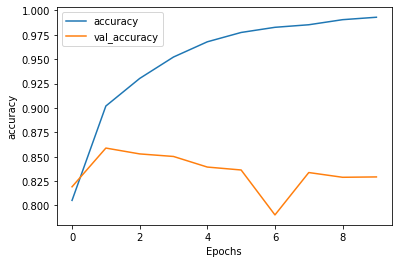

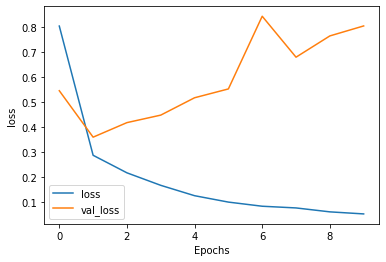

In [48]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()


plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()

In [49]:
# Model Definition with BiRNN (LSTM)
# with L2 Ridge Regularization
# Dropout, for robustness of recurrent neural networks
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 100)               6500      
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [50]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))


Epoch 1/10
376/376 [==============================] - 23s 54ms/step - loss: 0.4909 - accuracy: 0.7955 - val_loss: 0.5806 - val_accuracy: 0.6267
Epoch 2/10
376/376 [==============================] - 19s 50ms/step - loss: 0.2537 - accuracy: 0.9043 - val_loss: 0.3914 - val_accuracy: 0.8390
Epoch 3/10
376/376 [==============================] - 19s 50ms/step - loss: 0.1710 - accuracy: 0.9401 - val_loss: 0.4750 - val_accuracy: 0.8210
Epoch 4/10
376/376 [==============================] - 19s 51ms/step - loss: 0.1188 - accuracy: 0.9614 - val_loss: 0.4818 - val_accuracy: 0.8435
Epoch 5/10
376/376 [==============================] - 21s 55ms/step - loss: 0.0858 - accuracy: 0.9762 - val_loss: 0.5611 - val_accuracy: 0.8454
Epoch 6/10
376/376 [==============================] - 21s 55ms/step - loss: 0.0664 - accuracy: 0.9819 - val_loss: 1.1520 - val_accuracy: 0.7712
Epoch 7/10
376/376 [==============================] - 19s 51ms/step - loss: 0.0552 - accuracy: 0.9859 - val_loss: 0.7060 - val_accuracy:

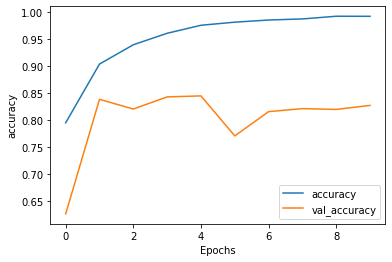

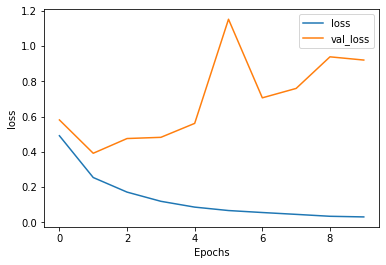

In [51]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()


In [52]:
# Model Definition with CNN (Conv1D)
# with L1 Lasso Regularization, for feature selection
# Dropout, for robustness
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_4 (Dense)             (None, 100)               12900     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 100)              

In [53]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))



Epoch 1/10
376/376 [==============================] - 4s 9ms/step - loss: 0.9831 - accuracy: 0.7716 - val_loss: 0.6575 - val_accuracy: 0.5934
Epoch 2/10
376/376 [==============================] - 3s 8ms/step - loss: 0.3354 - accuracy: 0.8891 - val_loss: 1.0616 - val_accuracy: 0.6342
Epoch 3/10
376/376 [==============================] - 3s 8ms/step - loss: 0.2761 - accuracy: 0.9145 - val_loss: 3.5600 - val_accuracy: 0.4433
Epoch 4/10
376/376 [==============================] - 3s 7ms/step - loss: 0.2385 - accuracy: 0.9304 - val_loss: 0.4304 - val_accuracy: 0.8555
Epoch 5/10
376/376 [==============================] - 3s 7ms/step - loss: 0.2173 - accuracy: 0.9360 - val_loss: 2.8059 - val_accuracy: 0.5912
Epoch 6/10
376/376 [==============================] - 3s 7ms/step - loss: 0.1970 - accuracy: 0.9445 - val_loss: 2.6445 - val_accuracy: 0.4961
Epoch 7/10
376/376 [==============================] - 3s 8ms/step - loss: 0.1876 - accuracy: 0.9480 - val_loss: 3.1073 - val_accuracy: 0.4661
Epoch 

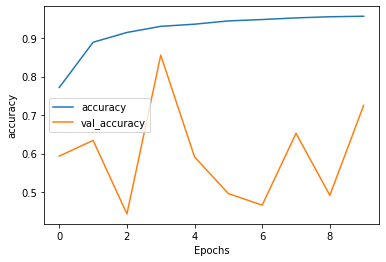

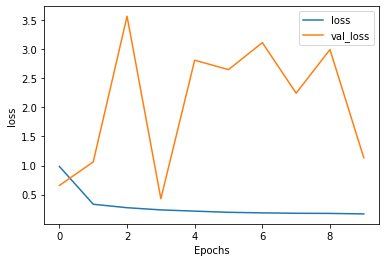

In [54]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()



In [67]:
import pickle

In [69]:
with open('model_pickle','wb') as f:
    pickle.dump(model,f)

INFO:tensorflow:Assets written to: ram://31d1e039-15fe-43ca-9a01-290d4a43ea68/assets


INFO:tensorflow:Assets written to: ram://31d1e039-15fe-43ca-9a01-290d4a43ea68/assets


In [10]:
import pickle
with open('model_pickle','rb') as f:
    m1 = pickle.load(f)

In [13]:

h = m1.predict(testing_sequences)

NameError: name 'testing_sequences' is not defined

# CNN

For the prediction of sarcasm of headlines, we will use CNN with the following architectures:

    CNN with Conv1D


In [55]:
# Model Definition with CNN (Conv1D)
# with L2 Ridge Regularization
# Dropout, for robustness
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d_1 (Conv1D)           (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 100)               12900     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                      

In [56]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))



Epoch 1/10
376/376 [==============================] - 5s 11ms/step - loss: 0.6559 - accuracy: 0.6582 - val_loss: 0.4413 - val_accuracy: 0.8225
Epoch 2/10
376/376 [==============================] - 3s 8ms/step - loss: 0.3714 - accuracy: 0.8618 - val_loss: 0.3726 - val_accuracy: 0.8574
Epoch 3/10
376/376 [==============================] - 3s 8ms/step - loss: 0.3016 - accuracy: 0.8981 - val_loss: 0.3672 - val_accuracy: 0.8577
Epoch 4/10
376/376 [==============================] - 4s 10ms/step - loss: 0.2583 - accuracy: 0.9178 - val_loss: 0.3711 - val_accuracy: 0.8592
Epoch 5/10
376/376 [==============================] - 4s 10ms/step - loss: 0.2287 - accuracy: 0.9316 - val_loss: 0.3821 - val_accuracy: 0.8600
Epoch 6/10
376/376 [==============================] - 3s 9ms/step - loss: 0.2082 - accuracy: 0.9417 - val_loss: 0.4015 - val_accuracy: 0.8529
Epoch 7/10
376/376 [==============================] - 3s 8ms/step - loss: 0.1896 - accuracy: 0.9507 - val_loss: 0.4137 - val_accuracy: 0.8521
Epo

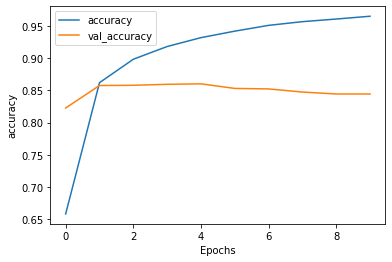

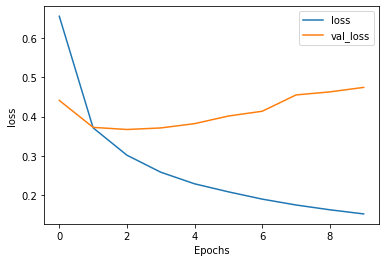

In [57]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()



# CNN-RNN combined architecture

For the prediction of sarcasm of headlines, we will use the following architecture:

    Combination of CNN-RNN (LSTM)
        Output from CNN with Conv1D is used as input for RNN with LSTM (with Lasso Regularization, Dropout)


In [58]:
# Model Definition with CNN (Conv1D)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 1, activation='relu'),
    tf.keras.layers.MaxPooling1D(2, padding="same"),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.005), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(0.005), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d_2 (Conv1D)           (None, 120, 128)          2176      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 60, 128)          0         
 )                                                               
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 100)               6500      
                                                                 
 dropout_4 (Dropout)         (None, 100)              

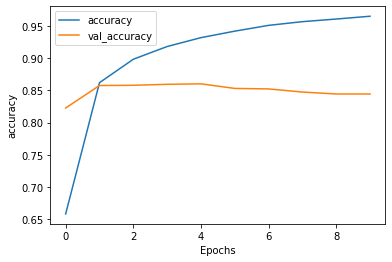

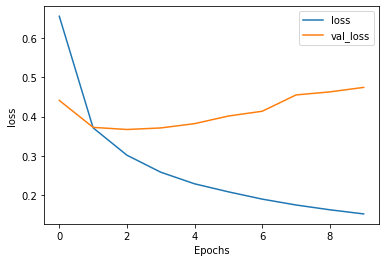

In [59]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()



# RNN with GRU

In [60]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


In [61]:
# Model Definition with BiRNN (GRU)
# with L1 Lasso Regularization, for feature selection
# Dropout, for robustness of recurrent neural networks
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 100)               6500      
                                                                 
 batch_normalization_3 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                

In [62]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))



Epoch 1/10
376/376 [==============================] - 27s 65ms/step - loss: 0.8481 - accuracy: 0.7764 - val_loss: 0.5210 - val_accuracy: 0.8660
Epoch 2/10
376/376 [==============================] - 24s 63ms/step - loss: 0.2906 - accuracy: 0.8982 - val_loss: 0.4199 - val_accuracy: 0.8192
Epoch 3/10
376/376 [==============================] - 23s 60ms/step - loss: 0.2358 - accuracy: 0.9182 - val_loss: 1.3274 - val_accuracy: 0.7042
Epoch 4/10
376/376 [==============================] - 22s 59ms/step - loss: 0.1665 - accuracy: 0.9540 - val_loss: 0.4807 - val_accuracy: 0.8469
Epoch 5/10
376/376 [==============================] - 22s 60ms/step - loss: 0.1212 - accuracy: 0.9702 - val_loss: 0.5485 - val_accuracy: 0.8413
Epoch 6/10
376/376 [==============================] - 22s 59ms/step - loss: 0.0977 - accuracy: 0.9771 - val_loss: 0.5630 - val_accuracy: 0.8398
Epoch 7/10
376/376 [==============================] - 23s 60ms/step - loss: 0.0766 - accuracy: 0.9847 - val_loss: 0.6740 - val_accuracy:

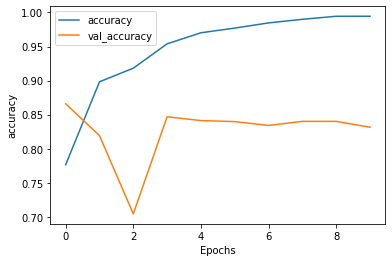

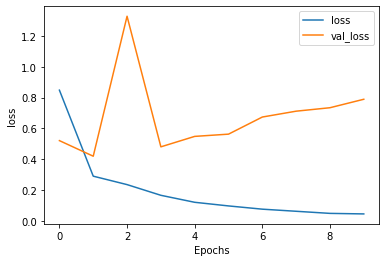

In [63]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()



In [64]:
# Model Definition with BiRNN (GRU)
# with L2 Ridge Regularization
# Dropout, for robustness of recurrent neural networks
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 100)               6500      
                                                                 
 batch_normalization_4 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                

In [65]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))



Epoch 1/10
376/376 [==============================] - 25s 61ms/step - loss: 0.5292 - accuracy: 0.7721 - val_loss: 0.5131 - val_accuracy: 0.7492
Epoch 2/10
376/376 [==============================] - 22s 58ms/step - loss: 0.2673 - accuracy: 0.8953 - val_loss: 0.6501 - val_accuracy: 0.7042
Epoch 3/10
376/376 [==============================] - 22s 58ms/step - loss: 0.1782 - accuracy: 0.9360 - val_loss: 0.4105 - val_accuracy: 0.8267
Epoch 4/10
376/376 [==============================] - 22s 58ms/step - loss: 0.1246 - accuracy: 0.9582 - val_loss: 0.8031 - val_accuracy: 0.7656
Epoch 5/10
376/376 [==============================] - 23s 61ms/step - loss: 0.0844 - accuracy: 0.9728 - val_loss: 0.5614 - val_accuracy: 0.8338
Epoch 6/10
376/376 [==============================] - 22s 59ms/step - loss: 0.0665 - accuracy: 0.9799 - val_loss: 0.6251 - val_accuracy: 0.8435
Epoch 7/10
376/376 [==============================] - 22s 57ms/step - loss: 0.0493 - accuracy: 0.9857 - val_loss: 0.7307 - val_accuracy:

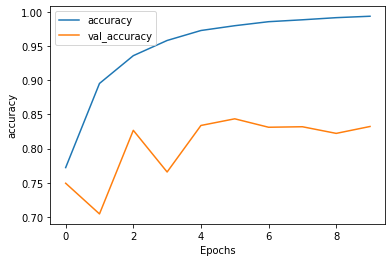

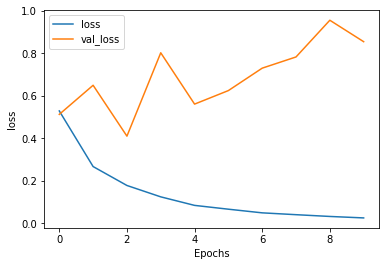

In [66]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()
